# Project Time Series Workshop I Part 1

```
By: Costin-Andrei Taulescu & Panagiotis Valsamis
```

In the following project, we will explore time series data analysis and forecasting using Python.
- We are using Walmart's historical sales data for this project.
- The dataset includes weekly sales data for various departments across multiple stores.
- The following project is divided into two main parts:
    - Compare forecasting at the smallest unit level vs at an aggregated level.
    - Make as much accurate forecasts as possible in order to maximize the chances of getting a rebate laid out in a contract between the store and the suppliers.


## Reproducibility: Ensuring Consistent Environment and Rerunability

We recommend creating a virtual environment to run this notebook, to ensure that all dependencies are properly managed.

---

Make sure python 3.7+ is installed on your system.

```
python --version

# or

python3 --version
```

**For Windows Users:**
```python
python -m venv ts_workshop_env
ts_workshop_env\Scripts\activate
pip install -r requirements.txt
```

---


**For macOS/Linux Users:**
```python
python3 -m venv ts_workshop_env
source ts_workshop_env/bin/activate
pip install -r requirements.txt
```
---



## Importing Necessary Libraries


In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta    
import warnings
from scipy import stats
from statsmodels.tsa.stattools import adfuller, kpss
import pymannkendall as mk
from scipy.stats import linregress

---

## Overview of the data

We will use only the train.csv file at least for Part I, based on the instructions of the project we will compare the two methods on department level as well.

In [61]:
df = pd.read_csv("data/train.csv")
print(df.shape) # Number of rows and columns
print(df.head()) # First few rows
print(df.describe()) # Statistical summary
print(df.info()) # Data types and non-null counts
print(df.isnull().sum()) # Count of missing values per column


(421570, 5)
   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False
               Store           Dept   Weekly_Sales
count  421570.000000  421570.000000  421570.000000
mean       22.200546      44.260317   15981.258123
std        12.785297      30.492054   22711.183519
min         1.000000       1.000000   -4988.940000
25%        11.000000      18.000000    2079.650000
50%        22.000000      37.000000    7612.030000
75%        33.000000      74.000000   20205.852500
max        45.000000      99.000000  693099.360000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         

---



For this part of the project, we will use only the store 1 and based on these we will proceed with the comparison of the two methods, one by forecasting based on a specific department as well and for the second method we will forecast at the aggregated level and then de-aggregate at the department level.

---



### Small overview of Store 1 data



In [62]:
df_store_1 = df[df['Store'] == 1]
print(df_store_1.shape) # Shape of the filtered DataFrame
print(df_store_1.head()) # First few rows of the filtered DataFrame
print(df_store_1["Dept"].sort_index().value_counts()) # Sorted count of unique values in 'Dept' column for Store 1
print(df_store_1.tail())


(10244, 5)
   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False
Dept
1     143
2     143
3     143
4     143
5     143
     ... 
99     37
51     33
47     22
78      4
77      3
Name: count, Length: 77, dtype: int64
       Store  Dept        Date  Weekly_Sales  IsHoliday
10239      1    99  2012-08-31         20.06      False
10240      1    99  2012-09-07          0.05       True
10241      1    99  2012-09-14          0.03      False
10242      1    99  2012-10-05        635.00      False
10243      1    99  2012-10-12         80.00      False


---

**Note:**
```
Based on the initial df.describe() we made, we observe that there are some negative values in weekly_sales, something that does not make sense at all. So in the following blocks, we will remove these values from our df_store1.
```

---

In [63]:
# Function to filter rows with negative values in a specified column
def negative_values(df, column_name):
    return df[df[column_name] < 0]

In [64]:
print(df_store_1.describe())
negative_values(df_store_1,"Weekly_Sales")

         Store          Dept   Weekly_Sales
count  10244.0  10244.000000   10244.000000
mean       1.0     44.391742   21710.543621
std        0.0     29.867247   27748.945511
min        1.0      1.000000    -863.000000
25%        1.0     20.000000    3465.622500
50%        1.0     38.000000   10289.375000
75%        1.0     72.000000   31452.957500
max        1.0     99.000000  203670.470000


,Store,Dept,Date,Weekly_Sales,IsHoliday
846,1,6,2012-08-10,-139.65,False
2384,1,18,2012-05-04,-1.27,False
6048,1,47,2010-02-19,-863.00,False
6049,1,47,2010-03-12,-698.00,False
6051,1,47,2010-10-08,-58.00,False
6056,1,47,2011-04-08,-298.00,False
6057,1,47,2011-07-08,-198.00,False
6061,1,47,2011-10-14,-498.00,False
6062,1,47,2011-12-23,-498.00,False
6063,1,47,2012-02-17,-198.00,False


In [65]:
# Function to set negative values in a specified column to zero
def make_negative_values_zero(df, column_name):
    df.loc[df[column_name] < 0, column_name] = 0
    return df

df_store_1 = make_negative_values_zero(df_store_1, "Weekly_Sales")

---

**Note:**
``` 
In the following blocks, we first tested method 2 and then method 1, so dont get confused by the final conclusion
```

## Part 1 - Method 2 Forecasting at the aggregated level and de-aggregating to department level


2012-10-26 00:00:00
2012-10-05 00:00:00
       Store  Dept       Date  Weekly_Sales  IsHoliday
10237      1    99 2012-08-17          0.06      False
10238      1    99 2012-08-24          0.07      False
10239      1    99 2012-08-31         20.06      False
10240      1    99 2012-09-07          0.05       True
10241      1    99 2012-09-14          0.03      False
       Store  Dept       Date  Weekly_Sales  IsHoliday
10204      1    98 2012-10-12      12861.92      False
10205      1    98 2012-10-19      13110.24      False
10206      1    98 2012-10-26      12702.86      False
10242      1    99 2012-10-05        635.00      False
10243      1    99 2012-10-12         80.00      False


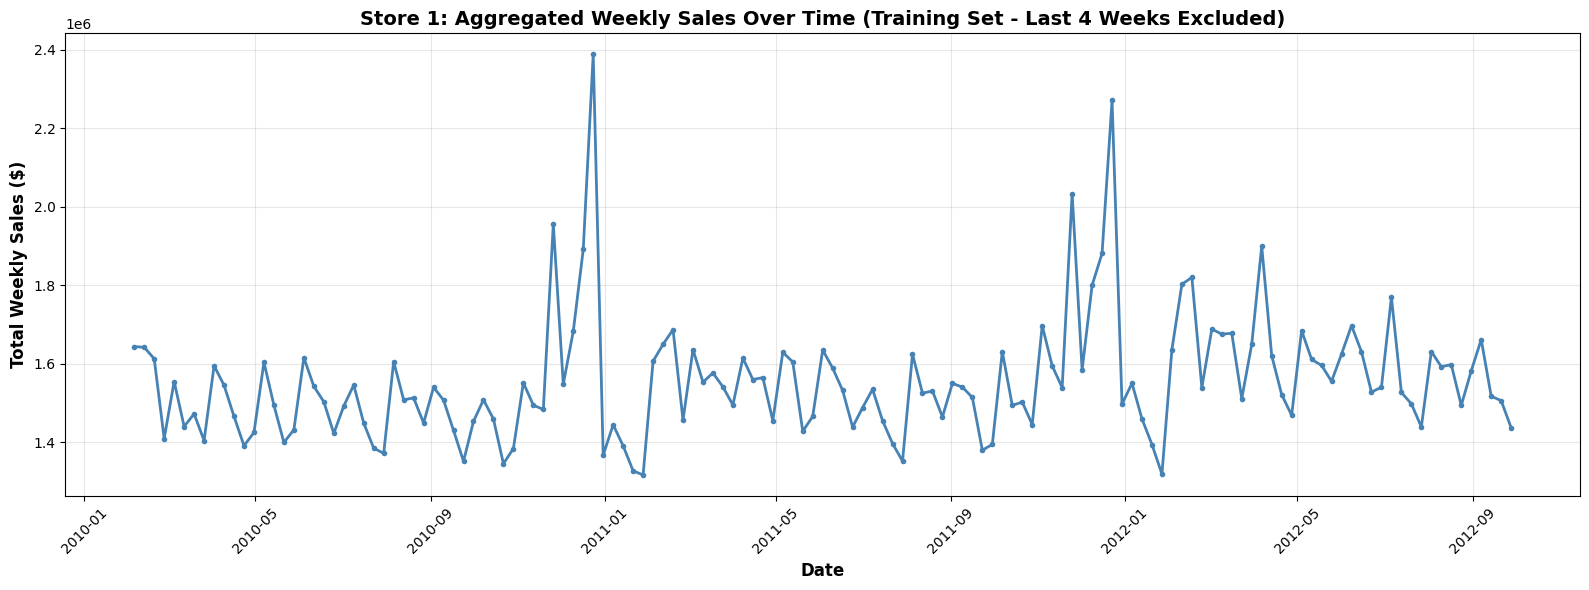

In [66]:
# Convert Date column to datetime if it's not already
df_store_1['Date'] = pd.to_datetime(df_store_1['Date'])

# First, identify the last 4 weeks cutoff -> Which we will use for testing later
max_date = df_store_1['Date'].max()
print(max_date)
test_start_date = max_date - pd.Timedelta(weeks=3)  # Last 4 weeks
print(test_start_date)

# Filter to exclude last 4 weeks (training data only)
df_store_1_train = df_store_1[df_store_1['Date'] < test_start_date].copy()
print(df_store_1_train.tail())

df_store_1_test = df_store_1[df_store_1['Date'] >= test_start_date].copy()
print(df_store_1_test.tail())
# Aggregate all departments by date (sum weekly sales across all departments)
store_1_aggregated_train = df_store_1_train.groupby('Date').agg({
    'Weekly_Sales': 'sum'
}).reset_index()
store_1_aggregated_test = df_store_1_test.groupby('Date').agg({
    'Weekly_Sales': 'sum'
}).reset_index()
# Sort by date
store_1_aggregated = store_1_aggregated_train.sort_values('Date').reset_index(drop=True)

# Create visualization
plt.figure(figsize=(16, 6))

# Plot the aggregated sales
plt.plot(store_1_aggregated['Date'], 
         store_1_aggregated['Weekly_Sales'], 
         linewidth=2, 
         color='steelblue',
         marker='o',
         markersize=3)

plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Total Weekly Sales ($)', fontsize=12, fontweight='bold')
plt.title('Store 1: Aggregated Weekly Sales Over Time (Training Set - Last 4 Weeks Excluded)', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()


---

### Some Observations 

- There is clear peak during the end of each year, which is expected due to holiday shopping.
- There is a clear low exactly in the beggining of each year, which is expected due to post-holiday season.
- The time series seems to be stationary(expectation and variance do not change over time), but lets check it more comprehensively with the following tests.


---

### Statistical Tests



``` 
We are applying some statistical tests to check for evidence of trend on our time series data. Please take a look on the "run_trend_analysis.py" file for more details on the functions used below.
```

In [ ]:
from run_trend_analysis import analyze_series

df_store_for_tests = store_1_aggregated_train["Weekly_Sales"]
# data
results = analyze_series(df_store_for_tests, series_name="Store 1")


######################################################################
COMPREHENSIVE TREND ANALYSIS FOR: Store 1
######################################################################

Data points: 139
Mean: 1555116.40
Std Dev: 157221.96
Min: 1316899.31
Max: 2387950.20

1. MANN-KENDALL TEST (Non-parametric)
Trend: increasing
Test Statistic (S): 1743.0
p-value: 0.001514
Tau (correlation): 0.181733
z-score: 3.172081

 RESULT: Significant trend detected (p < 0.05)
  Direction: increasing

2. AUGMENTED DICKEY-FULLER (ADF) TEST
ADF Statistic: -5.037909
p-value: 0.000019
Lags used: 4
Number of observations: 134

Critical Values:
  1%: -3.480
  5%: -2.883
  10%: -2.578

 RESULT: Series is stationary (p < 0.05)
   No unit root → Suggests NO trend

3. KPSS TEST (Kwiatkowski-Phillips-Schmidt-Shin)
KPSS Test (with trend):
KPSS Statistic: 0.058672
p-value: 0.100000
Lags used: 3

Critical Values:
  10%: 0.119
  5%: 0.146
  2.5%: 0.176
  1%: 0.216

 RESULT: Series is trend stationary (p >= 0.05)
  

```
Based on the statistical tests above we have mixed results, so even with them we can not be very sure if there is a trend or not. However, based on the observations we made on the time series plot above, we can see that the series does not exhibit a persistent upward or downward trend over time. Instead, it shows regular seasonal patterns without a clear long-term increase or decrease in sales. Therefore, we will proceed with the assumption that there is no significant trend present in the data.
```

```
After finishing with Holt-Winters, we will try to choose another model that can capture trend and seasonality to see if it improves forecast accuracy.
```

---

Aggregated weekly sales were modeled using Holt–Winters seasonal exponential smoothing without trend. Model parameters were selected via grid search by minimizing the Time Series Error (TSE), defined as the sum of squared in-sample errors and implemented manually. The selected model was then used to forecast the four-week test horizon, and forecast accuracy was evaluated on the test set.

**Note: Why we chose Holt–Winters (seasonal, no trend)**
```

Based on the observations above, the series exhibits clear and stable seasonality but no persistent long-term trend. Therefore, a Holt–Winters seasonal exponential smoothing model without a trend component was selected. Including a trend component in the presence of no systematic trend can increase model variance and lead to overfitting, without improving forecast accuracy.

```


---

**Note:**
```
We are using additive seasonality because the seasonal fluctuations appear to be relatively constant in magnitude over time, rather than increasing or decreasing proportionally with the level of the series. In other words, the difference between peak and trough sales remains fairly stable throughout the years, indicating that an additive model is more appropriate for capturing the seasonal patterns in this data. However, we will test multiplicative seasonality as well to see if it improves the forecast accuracy, even though based on the observations it should not.
```

Test TSE: 775926584.9234535
Test RMSE: 13927.729399685484


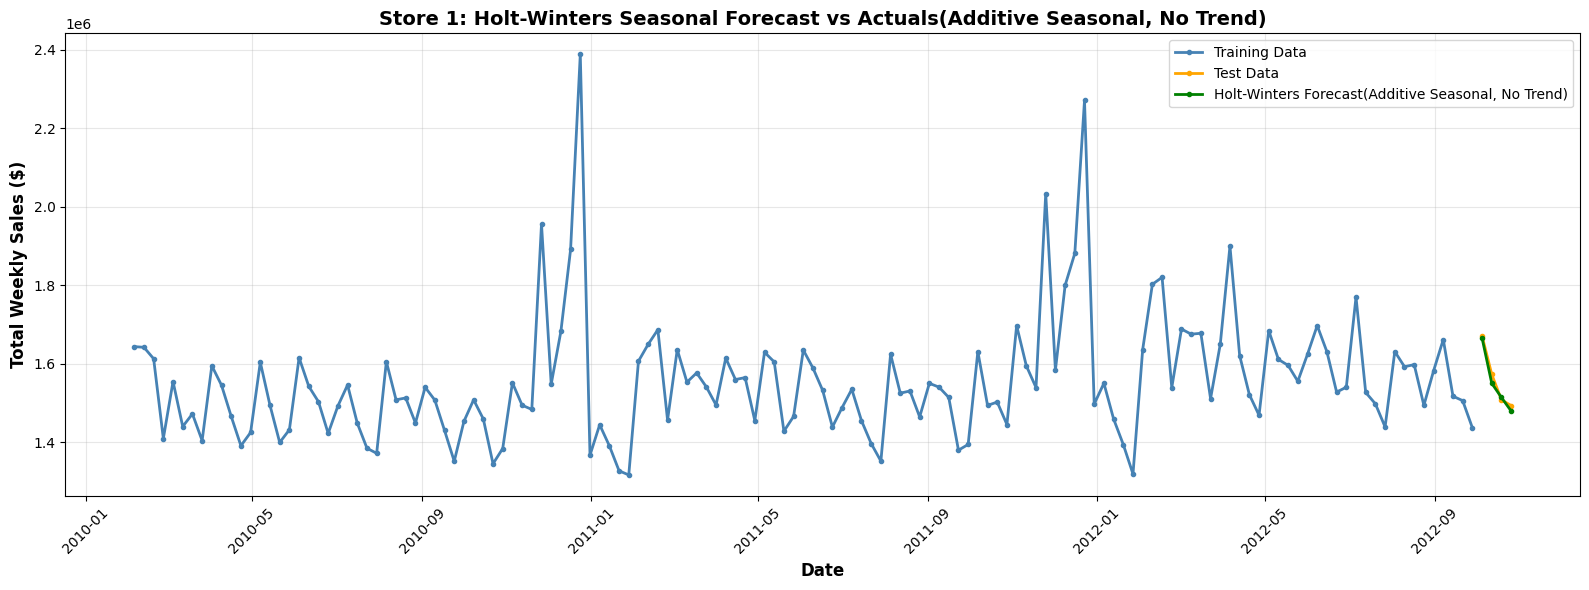

In [68]:
#-----------------------------
# Additive Holt-Winters Seasonal Method without Trend
#-----------------------------

def TSE(y_true,y_pred):
    return np.sum((y_true - y_pred)**2)

def hw_seasonal_no_trend(y,alpha,gamma,m):
    """
    Holt-Winters Seasonal Method without Trend
    y: time series data
    alpha: level smoothing parameter
    gamma: seasonal smoothing parameter
    m:season length
    """

    n =len(y)
    # Initialization
    level = np.mean(y[:m])  # Mean of first seasonal cycle
    seasonals = list(y[:m] - level)  # Seasonal components for first cycle

    fitted = [np.nan]*n

    for t in range(m,n):
        fitted[t] = level + seasonals[t -  m]

        new_level = alpha * (y[t] - seasonals[t - m]) + (1 - alpha) * level
        new_seasonal = gamma * (y[t] - new_level) + (1 - gamma) * seasonals[t - m]

        level = new_level
        seasonals.append(new_seasonal)

    return np.array(fitted), level, seasonals

y_train = store_1_aggregated_train["Weekly_Sales"].values
m = 52

alphas = np.arange(0.05, 1.0, 0.05)
gammas = np.arange(0.05, 1.0, 0.05)

best_tse = np.inf
best_params = None
best_model = None

for alpha in alphas:
    for gamma in gammas:
        fitted, level, seasonals = hw_seasonal_no_trend(
            y_train, alpha, gamma, m
        )
        
        valid_idx = ~np.isnan(fitted)
        tse = TSE(y_train[valid_idx], fitted[valid_idx])
        
        if tse < best_tse:
            best_tse = tse
            best_params = (alpha, gamma)
            best_model = (level, seasonals)



h = len(store_1_aggregated_test)
alpha_best, gamma_best = best_params
level, seasonals = best_model

seasonals = np.array(seasonals)

forecast = []
for i in range(h):
    seasonal_index = len(seasonals) - m + i
    forecast.append(level + seasonals[seasonal_index])

forecast = np.array(forecast)


y_test = store_1_aggregated_test["Weekly_Sales"].values

tse_test = TSE(y_test, forecast)
rmse_test = np.sqrt(np.mean((y_test - forecast) ** 2))
mae_test = np.mean(np.abs(y_test - forecast))

print(f"Test TSE: {tse_test}")
print(f"Test RMSE: {rmse_test}")
plt.figure(figsize=(16, 6))
plt.plot(store_1_aggregated['Date'], 
         store_1_aggregated['Weekly_Sales'], 
         label='Training Data',
         linewidth=2, 
         color='steelblue',
         marker='o',
         markersize=3)

plt.plot(store_1_aggregated_test['Date'], 
         store_1_aggregated_test['Weekly_Sales'],
            label='Test Data',
            linewidth=2,
            color='orange',
            marker='o',
            markersize=3)

plt.plot(store_1_aggregated_test['Date'],
            forecast,
            label='Holt-Winters Forecast(Additive Seasonal, No Trend)',
            linewidth=2,
            color='green',
            marker='o',
            markersize=3)   

plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Total Weekly Sales ($)', fontsize=12, fontweight='bold')    
plt.title('Store 1: Holt-Winters Seasonal Forecast vs Actuals(Additive Seasonal, No Trend)', 
          fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Store results from additive model
additive_results = {
    'alpha': best_params[0],
    'gamma': best_params[1],
    'tse_train': best_tse,
    'tse_test': tse_test,
    'rmse_test': rmse_test,
    'mae_test': mae_test,
    'forecast': forecast.copy()  # Store the forecast
}


---

```
In order to understand better the performance of the model, we will visualize just the predictions and the actual test data on a plot.
```

---

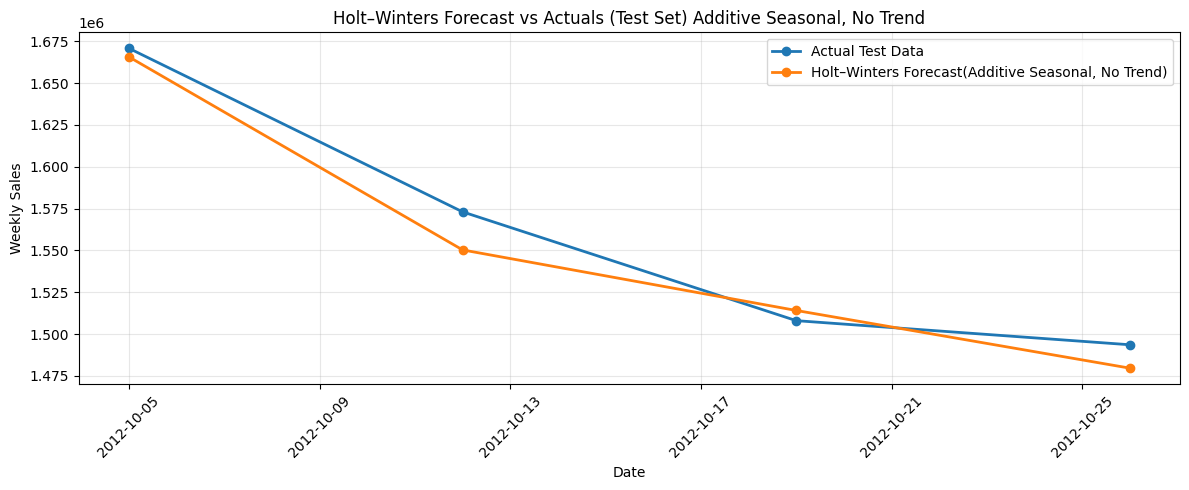

In [69]:
plt.figure(figsize=(12, 5))

plt.plot(
    store_1_aggregated_test['Date'],
    y_test,
    label='Actual Test Data',
    marker='o',
    linewidth=2
)

plt.plot(
    store_1_aggregated_test['Date'],
    forecast,
    label='Holt–Winters Forecast(Additive Seasonal, No Trend)',
    marker='o',
    linewidth=2
)

plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Holt–Winters Forecast vs Actuals (Test Set) Additive Seasonal, No Trend')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Multiplicative Seasonality Holt-Winters Model

---

Best parameters: alpha=0.15, gamma=0.70
Best TSE (training): 405240934553.55

Test TSE: 842717466.42
Test RMSE: 14514.80
Test MAE: 11739.95


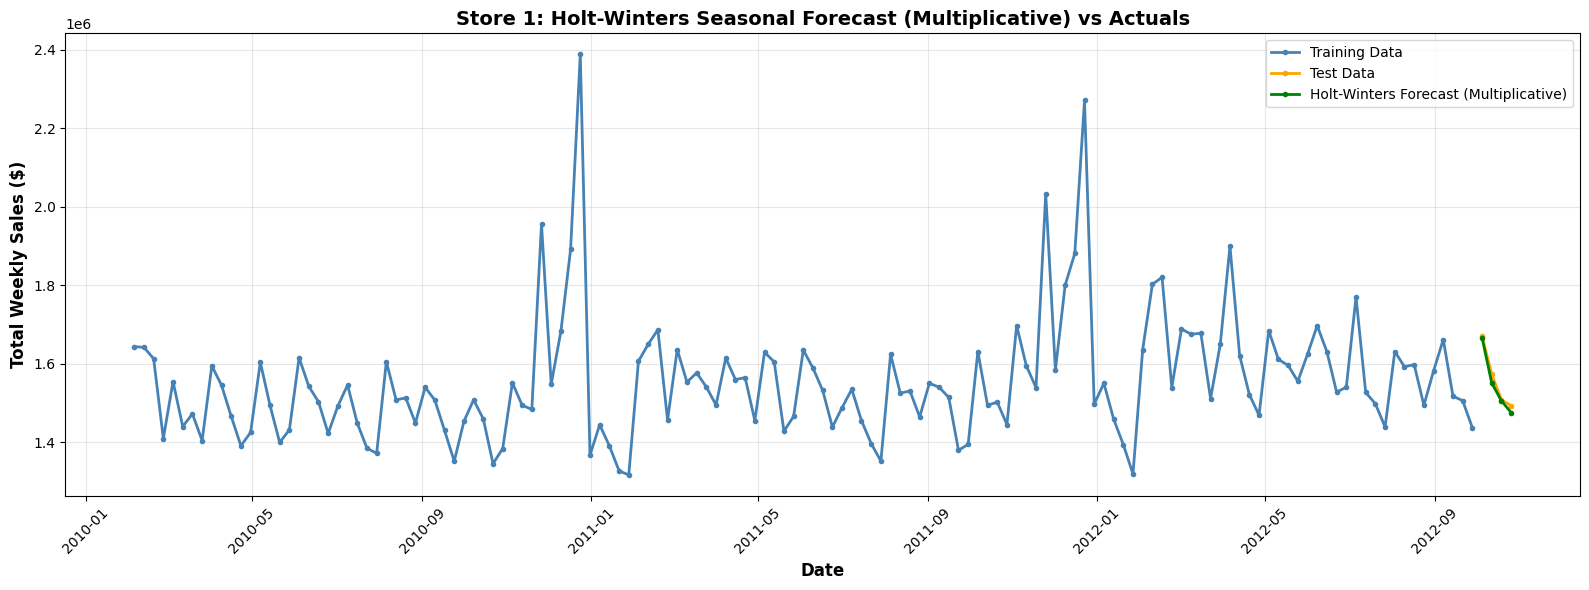

In [70]:
def hw_seasonal_no_trend_multiplicative(y, alpha, gamma, m):
    """
    Holt-Winters Seasonal Method without Trend - Multiplicative Seasonality
    y: time series data
    alpha: level smoothing parameter
    gamma: seasonal smoothing parameter
    m: season length
    """
    
    n = len(y)
    
    # Initialization
    level = np.mean(y[:m])
    seasonals = list(y[:m] / level)  # Multiplicative: divide instead of subtract
    
    fitted = [np.nan] * n
    
    for t in range(m, n):
        fitted[t] = level * seasonals[t - m]  # Multiplicative: multiply instead of add
        
        # Update level (deseasonalize by dividing)
        new_level = alpha * (y[t] / seasonals[t - m]) + (1 - alpha) * level
        
        # Update seasonal component (ratio)
        new_seasonal = gamma * (y[t] / new_level) + (1 - gamma) * seasonals[t - m]
        
        level = new_level
        seasonals.append(new_seasonal)
    
    return np.array(fitted), level, seasonals


# Grid search for optimal parameters
y_train = store_1_aggregated_train["Weekly_Sales"].values
m = 52

alphas = np.arange(0.05, 1.0, 0.05)
gammas = np.arange(0.05, 1.0, 0.05)

best_tse = np.inf
best_params = None
best_model = None

for alpha in alphas:
    for gamma in gammas:
        fitted, level, seasonals = hw_seasonal_no_trend_multiplicative(
            y_train, alpha, gamma, m
        )
        
        valid_idx = ~np.isnan(fitted)
        tse = TSE(y_train[valid_idx], fitted[valid_idx])
        
        if tse < best_tse:
            best_tse = tse
            best_params = (alpha, gamma)
            best_model = (level, seasonals)

print(f"Best parameters: alpha={best_params[0]:.2f}, gamma={best_params[1]:.2f}")
print(f"Best TSE (training): {best_tse:.2f}")

# Forecasting
h = len(store_1_aggregated_test)
alpha_best, gamma_best = best_params
level, seasonals = best_model

seasonals = np.array(seasonals)

forecast = []
for i in range(h):
    seasonal_index = len(seasonals) - m + i
    forecast.append(level * seasonals[seasonal_index])  # Multiplicative

forecast = np.array(forecast)

# Evaluation
y_test = store_1_aggregated_test["Weekly_Sales"].values

tse_test = TSE(y_test, forecast)
rmse_test = np.sqrt(np.mean((y_test - forecast) ** 2))
mae_test = np.mean(np.abs(y_test - forecast))

print(f"\nTest TSE: {tse_test:.2f}")
print(f"Test RMSE: {rmse_test:.2f}")
print(f"Test MAE: {mae_test:.2f}")

# Visualization
plt.figure(figsize=(16, 6))
plt.plot(store_1_aggregated_train['Date'], 
         store_1_aggregated_train['Weekly_Sales'], 
         label='Training Data',
         linewidth=2, 
         color='steelblue',
         marker='o',
         markersize=3)

plt.plot(store_1_aggregated_test['Date'], 
         store_1_aggregated_test['Weekly_Sales'],
         label='Test Data',
         linewidth=2,
         color='orange',
         marker='o',
         markersize=3)

plt.plot(store_1_aggregated_test['Date'],
         forecast,
         label='Holt-Winters Forecast (Multiplicative)',
         linewidth=2,
         color='green',
         marker='o',
         markersize=3)   

plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Total Weekly Sales ($)', fontsize=12, fontweight='bold')    
plt.title('Store 1: Holt-Winters Seasonal Forecast (Multiplicative) vs Actuals', 
          fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

multiplicative_results = {
    'alpha': best_params[0],
    'gamma': best_params[1],
    'tse_train': best_tse,
    'tse_test': tse_test,
    'rmse_test': rmse_test,
    'mae_test': mae_test,
    'forecast': forecast.copy()  # Store the forecast
}


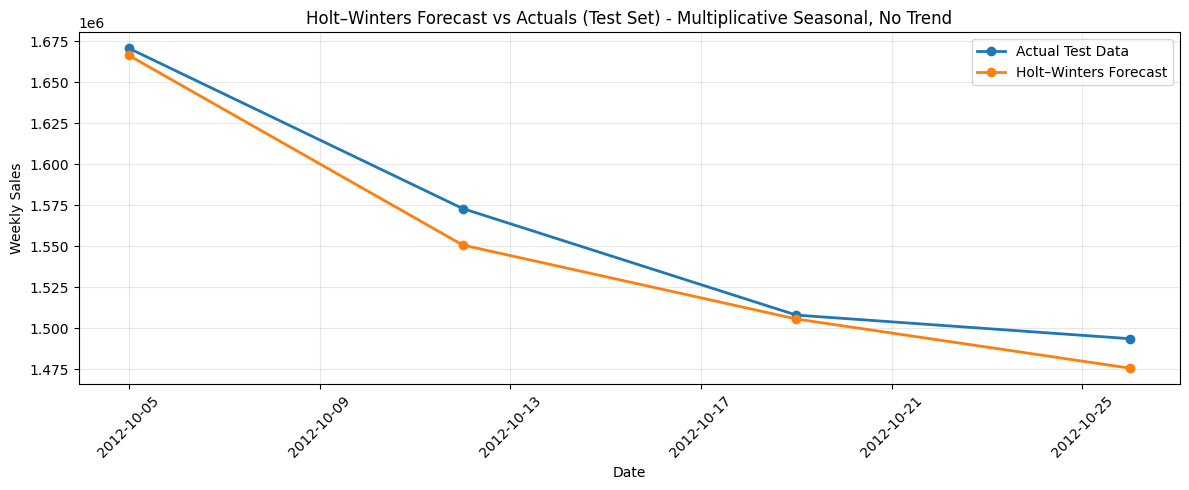

In [71]:
plt.figure(figsize=(12, 5))

plt.plot(
    store_1_aggregated_test['Date'],
    y_test,
    label='Actual Test Data',
    marker='o',
    linewidth=2
)

plt.plot(
    store_1_aggregated_test['Date'],
    forecast,
    label='Holt–Winters Forecast',
    marker='o',
    linewidth=2
)

plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Holt–Winters Forecast vs Actuals (Test Set) - Multiplicative Seasonal, No Trend')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---

### Comparison of the two methods(Additive Seasonality vs Multiplicative Seasonality)

MODEL COMPARISON: ADDITIVE VS MULTIPLICATIVE SEASONALITY

Additive Model:
  Best parameters: alpha=0.15, gamma=0.75
  Training TSE: 388685740510.08
  Test TSE:     775926584.92
  Test RMSE:    13927.73
  Test MAE:     11983.60

Multiplicative Model:
  Best parameters: alpha=0.15, gamma=0.70
  Training TSE: 405240934553.55
  Test TSE:     842717466.42
  Test RMSE:    14514.80
  Test MAE:     11739.95

Differences (Multiplicative - Additive):
  ΔTSE:  66790881.49
  ΔRMSE: 587.07
  ΔMAE:  -243.65

Better performing model: ADDITIVE
RMSE improvement: 587.07


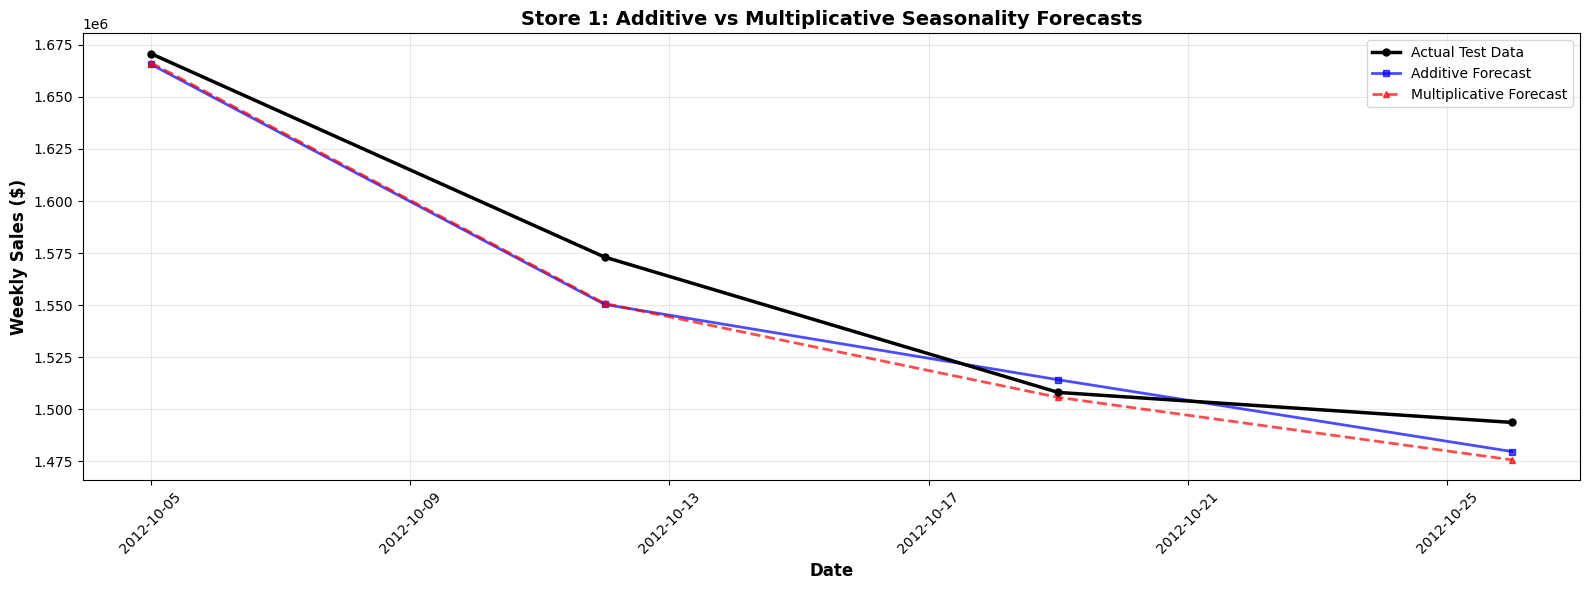

In [72]:
#-----------------------------
# Comparison Table
#-----------------------------
print("="*80)
print("MODEL COMPARISON: ADDITIVE VS MULTIPLICATIVE SEASONALITY")
print("="*80)

print("\nAdditive Model:")
print(f"  Best parameters: alpha={additive_results['alpha']:.2f}, gamma={additive_results['gamma']:.2f}")
print(f"  Training TSE: {additive_results['tse_train']:.2f}")
print(f"  Test TSE:     {additive_results['tse_test']:.2f}")
print(f"  Test RMSE:    {additive_results['rmse_test']:.2f}")
print(f"  Test MAE:     {additive_results['mae_test']:.2f}")

print("\nMultiplicative Model:")
print(f"  Best parameters: alpha={multiplicative_results['alpha']:.2f}, gamma={multiplicative_results['gamma']:.2f}")
print(f"  Training TSE: {multiplicative_results['tse_train']:.2f}")
print(f"  Test TSE:     {multiplicative_results['tse_test']:.2f}")
print(f"  Test RMSE:    {multiplicative_results['rmse_test']:.2f}")
print(f"  Test MAE:     {multiplicative_results['mae_test']:.2f}")

# Calculate differences
print("\nDifferences (Multiplicative - Additive):")
print(f"  ΔTSE:  {multiplicative_results['tse_test'] - additive_results['tse_test']:.2f}")
print(f"  ΔRMSE: {multiplicative_results['rmse_test'] - additive_results['rmse_test']:.2f}")
print(f"  ΔMAE:  {multiplicative_results['mae_test'] - additive_results['mae_test']:.2f}")

# Determine which is better
if additive_results['rmse_test'] < multiplicative_results['rmse_test']:
    better_model = "ADDITIVE"
    rmse_improvement = multiplicative_results['rmse_test'] - additive_results['rmse_test']
elif multiplicative_results['rmse_test'] < additive_results['rmse_test']:
    better_model = "MULTIPLICATIVE"
    rmse_improvement = additive_results['rmse_test'] - multiplicative_results['rmse_test']
else:
    better_model = "EQUIVALENT"
    rmse_improvement = 0

print(f"\nBetter performing model: {better_model}")
if better_model != "EQUIVALENT":
    print(f"RMSE improvement: {rmse_improvement:.2f}")

#-----------------------------
# Side-by-Side Forecast Comparison
#-----------------------------
plt.figure(figsize=(16, 6))

plt.plot(store_1_aggregated_test['Date'], 
         y_test,
         label='Actual Test Data',
         marker='o',
         linewidth=2.5,
         color='black',
         markersize=5,
         zorder=3)

plt.plot(store_1_aggregated_test['Date'],
         additive_results['forecast'],
         label='Additive Forecast',
         marker='s',
         linewidth=2,
         color='blue',
         markersize=4,
         alpha=0.7)

plt.plot(store_1_aggregated_test['Date'],
         multiplicative_results['forecast'],
         label='Multiplicative Forecast',
         marker='^',
         linewidth=2,
         color='red',
         markersize=4,
         alpha=0.7,
         linestyle='--')

plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Weekly Sales ($)', fontsize=12, fontweight='bold')
plt.title('Store 1: Additive vs Multiplicative Seasonality Forecasts', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---

## Conclusion

The additive and multiplicative seasonality models produce nearly identical forecasts for Store 1's aggregated weekly sales, with only a small difference in RMSE. This similarity occurs because:

1. STABLE SEASONAL VARIATION: The seasonal fluctuations remain relatively constant in absolute terms across different sales levels. The data doesn't exhibit strong proportional seasonality where peaks and troughs grow with the baseline.

2. LIMITED LEVEL VARIATION: Store 1's aggregated sales vary within a narrow range making additive and multiplicative formulations mathematically similar for this scale.

3. AGGREGATION EFFECT: Aggregating across all departments within Store 1 smooths out individual department volatility, resulting in more stable seasonal patterns that are well-captured by either model.

IMPLICATION FOR METHOD 2 (AGGREGATE-THEN-DISAGGREGATE):
While both models perform similarly at the aggregated store level, this may not holdwhen disaggregating back to individual departments or when applying Method 1 (directforecasting) to individual Store-Department combinations. Individual departments may exhibit:
  - Stronger growth/decline trends
  - More volatile seasonal patterns  
  - Proportional seasonality (e.g., holiday peaks scale with department size)

---

Next step is to disaggregate the forecasts back to the department level based on their historical proportions of sales within Store 1.We will use the department 1 for this disaggregation example and for later comparison with Method 1.

(139, 5)
(139, 2)
        Date  Weekly_Sales_dept  Weekly_Sales_store
0 2010-02-05           24924.50          1643690.90
1 2010-02-12           46039.49          1641957.44
2 2010-02-19           41595.55          1612831.17
3 2010-02-26           19403.54          1409727.59
4 2010-03-05           21827.90          1554806.68
Department 1's proportion of Store 1 sales:
  Mean: 0.0143 (1.43%)
  Std:  0.0054
  Based on all 139 training weeks


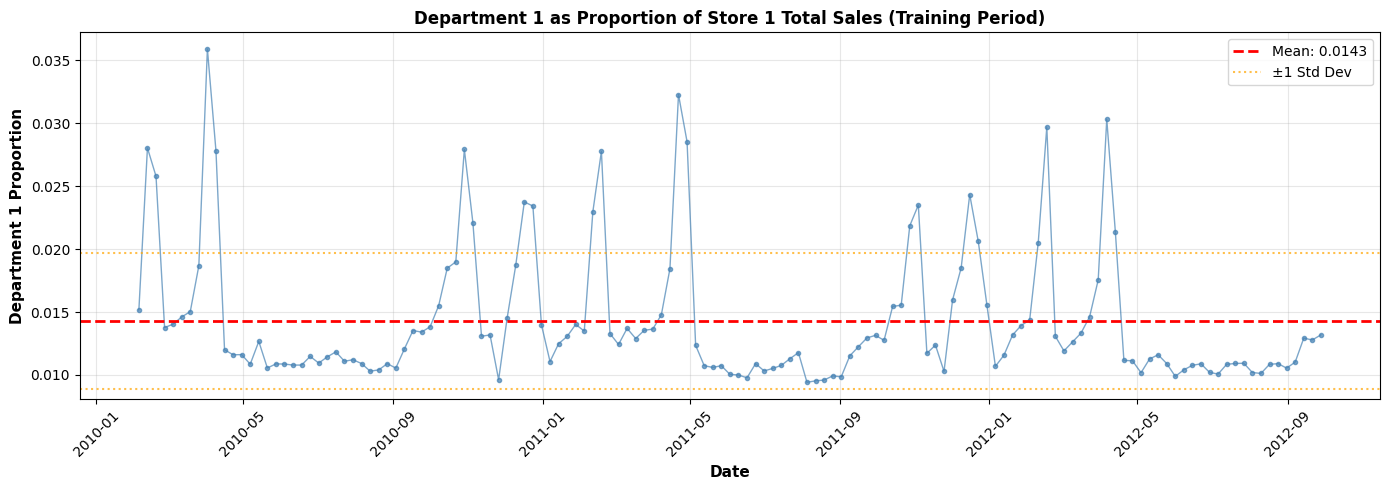


Department 1 Disaggregated Forecast Performance (Method 2):
  Test TSE:  49541178.78
  Test RMSE: 3519.27
  Test MAE:  2827.42


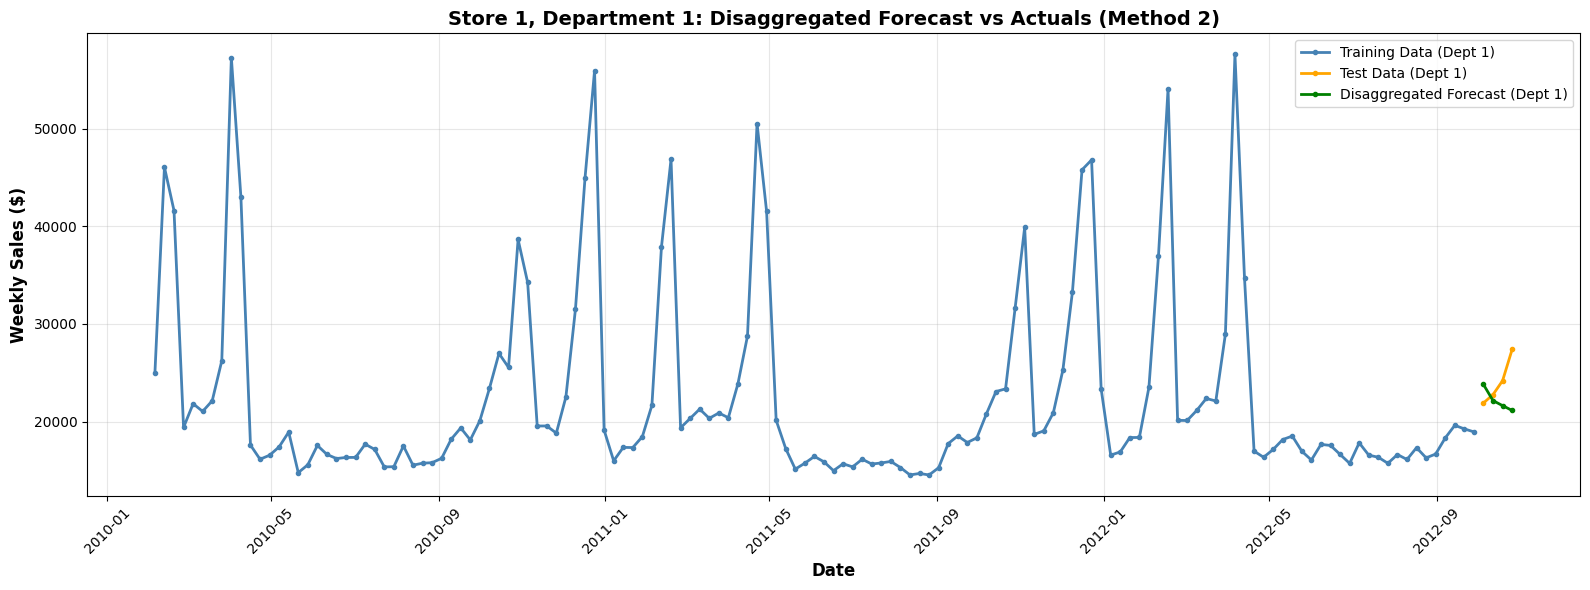

In [73]:
#-----------------------------
# Disaggregation: Store-Level Forecast → Department-Level Forecast
#-----------------------------

# Step 1: Calculate historical proportions for Department 1 within Store 1
# Use ALL training data for stable proportion estimate

# Filter for Store 1, Department 1 in training data
store_1_dept_1_train = df_store_1_train[(df_store_1_train['Store'] == 1) & (df_store_1_train['Dept'] == 1)].copy()
store_1_dept_1_train = store_1_dept_1_train.sort_values('Date')


# Merge ALL training weeks to align dates
all_merged = pd.merge(
    store_1_dept_1_train[['Date', 'Weekly_Sales']],
    store_1_aggregated_train[['Date', 'Weekly_Sales']], # Total store sales from above blocks of code
    on='Date',
    suffixes=('_dept', '_store')
)

print(store_1_dept_1_train.shape)
print(store_1_aggregated_train.shape)
#Note for the above merge: We are merging on 'Date' to align weekly sales for Department 1 with total Store 1 sales, to avoid any misalignment issues.
# Just in case there is a week missing from department 1 not to fufil it with zero proportion
print(all_merged.head())

# Calculate historical proportion for each week
all_merged['proportion'] = all_merged['Weekly_Sales_dept'] / all_merged['Weekly_Sales_store']

# Average across all training weeks
avg_proportion = all_merged['proportion'].mean()
std_proportion = all_merged['proportion'].std()

print(f"Department 1's proportion of Store 1 sales:")
print(f"  Mean: {avg_proportion:.4f} ({avg_proportion*100:.2f}%)")
print(f"  Std:  {std_proportion:.4f}")
print(f"  Based on all {len(all_merged)} training weeks")

# Visualize proportion stability over time
plt.figure(figsize=(14, 5))
plt.plot(all_merged['Date'], all_merged['proportion'], 
         marker='o', linewidth=1, markersize=3, alpha=0.7, color='steelblue')
plt.axhline(y=avg_proportion, color='red', linestyle='--', linewidth=2, 
            label=f'Mean: {avg_proportion:.4f}')
plt.axhline(y=avg_proportion + std_proportion, color='orange', linestyle=':', linewidth=1.5, alpha=0.7,
            label=f'±1 Std Dev')
plt.axhline(y=avg_proportion - std_proportion, color='orange', linestyle=':', linewidth=1.5, alpha=0.7)
plt.xlabel('Date', fontsize=11, fontweight='bold')
plt.ylabel('Department 1 Proportion', fontsize=11, fontweight='bold')
plt.title('Department 1 as Proportion of Store 1 Total Sales (Training Period)', 
          fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 2: Disaggregate the store-level forecast
# Use the additive forecast from earlier (stored in additive_results)
dept_1_forecast = additive_results['forecast'] * avg_proportion

# Step 3: Get actual Department 1 test data for evaluation
store_1_dept_1_test = df_store_1_test[(df_store_1_test['Store'] == 1) & (df_store_1_test['Dept'] == 1)].copy()
store_1_dept_1_test = store_1_dept_1_test.sort_values('Date')

y_test_dept_1 = store_1_dept_1_test['Weekly_Sales'].values

# Step 4: Evaluate disaggregated forecast
tse_dept_1 = TSE(y_test_dept_1, dept_1_forecast)
rmse_dept_1 = np.sqrt(np.mean((y_test_dept_1 - dept_1_forecast) ** 2))
mae_dept_1 = np.mean(np.abs(y_test_dept_1 - dept_1_forecast))

print(f"\nDepartment 1 Disaggregated Forecast Performance (Method 2):")
print(f"  Test TSE:  {tse_dept_1:.2f}")
print(f"  Test RMSE: {rmse_dept_1:.2f}")
print(f"  Test MAE:  {mae_dept_1:.2f}")

# Step 5: Visualize Department 1 forecast
plt.figure(figsize=(16, 6))

# Plot training data
store_1_dept_1_train_plot = df_store_1_train[(df_store_1_train['Store'] == 1) & (df_store_1_train['Dept'] == 1)].copy()
store_1_dept_1_train_plot = store_1_dept_1_train_plot.sort_values('Date')

plt.plot(store_1_dept_1_train_plot['Date'],
         store_1_dept_1_train_plot['Weekly_Sales'],
         label='Training Data (Dept 1)',
         linewidth=2,
         color='steelblue',
         marker='o',
         markersize=3)

plt.plot(store_1_dept_1_test['Date'],
         y_test_dept_1,
         label='Test Data (Dept 1)',
         linewidth=2,
         color='orange',
         marker='o',
         markersize=3)

plt.plot(store_1_dept_1_test['Date'],
         dept_1_forecast,
         label='Disaggregated Forecast (Dept 1)',
         linewidth=2,
         color='green',
         marker='o',
         markersize=3)

plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Weekly Sales ($)', fontsize=12, fontweight='bold')
plt.title('Store 1, Department 1: Disaggregated Forecast vs Actuals (Method 2)', 
          fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---

**Notes:**
```
From the above graph, we can see that the forecasted sales for department 1 using the aggregate-then-disaggregate method does not capture the actual sales pattern very well. The forecasted values are significantly lower than the actual sales during the 3/4 of the test period, indicating that this method may not be effective for department-level forecasting in this case.
```

```
We expect that Method 1 (direct forecasting at the department level) will outperform Method 2 (aggregate-then-disaggregate) for department-level forecasts. This is because Method 1 can capture department-specific trends and seasonal patterns that are lost when aggregating sales across all departments in Method 2. As a result, we anticipate lower forecast errors (e.g., RMSE) for Method 1 compared to Method 2 when evaluating at the department level.
```



---

## Part I - Method 1 - Direct Forecasting at Department Level


In [74]:
df_store_1_dept_1 = df[(df['Store'] == 1) & (df['Dept'] == 1)]
df_store_1_dept_1 = make_negative_values_zero(df_store_1_dept_1, "Weekly_Sales")
df_store_1_dept_1['Date'] = pd.to_datetime(df_store_1_dept_1['Date'])
df_store_1_dept_1_train = df_store_1_dept_1[df_store_1_dept_1['Date'] < test_start_date].copy()
df_store_1_dept_1_test = df_store_1_dept_1[df_store_1_dept_1['Date'] >= test_start_date].copy()
df_store_1_dept_1_train = df_store_1_dept_1_train.sort_values('Date')
df_store_1_dept_1_test = df_store_1_dept_1_test.sort_values('Date')
print(df_store_1_dept_1_train.tail())
print(df_store_1_dept_1_test.tail())

     Store  Dept       Date  Weekly_Sales  IsHoliday
134      1     1 2012-08-31      16680.24      False
135      1     1 2012-09-07      18322.37       True
136      1     1 2012-09-14      19616.22      False
137      1     1 2012-09-21      19251.50      False
138      1     1 2012-09-28      18947.81      False
     Store  Dept       Date  Weekly_Sales  IsHoliday
139      1     1 2012-10-05      21904.47      False
140      1     1 2012-10-12      22764.01      False
141      1     1 2012-10-19      24185.27      False
142      1     1 2012-10-26      27390.81      False


---

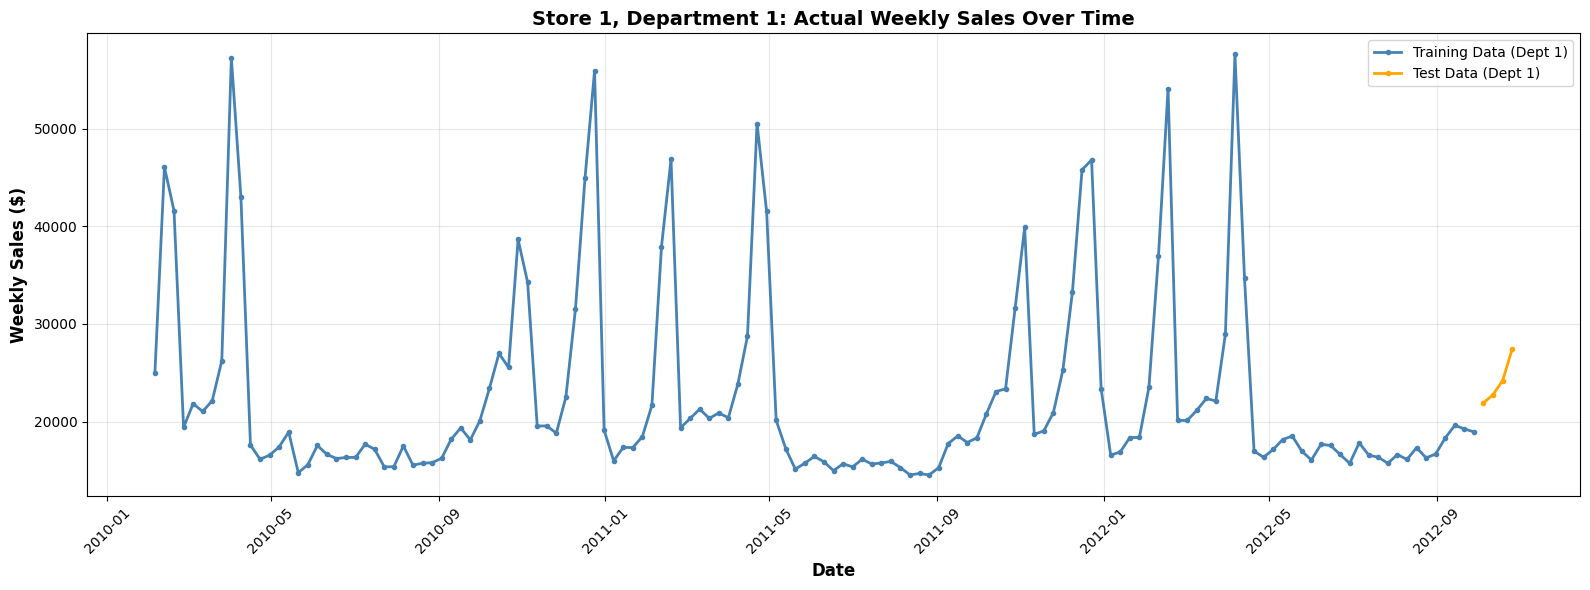

In [75]:
plt.figure(figsize=(16, 6))

plt.plot(df_store_1_dept_1_train['Date'],
         df_store_1_dept_1_train['Weekly_Sales'],
            label='Training Data (Dept 1)',
            linewidth=2,
            color='steelblue',
            marker='o',
            markersize=3)

plt.plot(df_store_1_dept_1_test['Date'],
            df_store_1_dept_1_test['Weekly_Sales'],
                label='Test Data (Dept 1)',
                linewidth=2,
                color='orange',
                marker='o',
                markersize=3)
plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Weekly Sales ($)', fontsize=12, fontweight='bold')
plt.title('Store 1, Department 1: Actual Weekly Sales Over Time', 
          fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---

**Observations:**
```
We can observe that department 1 has a clear seasonal pattern with peaks around the end of each year and troughs at the beginning of each year. There are also some noticeable spikes in sales during certain weeks(one might be easter week for example). Overall, the sales appear to be relatively stable with regular fluctuations throughout the years(at least one the two whole years that we have on our training data there seems to be a very similar pattern at all).
```

Again we will apply the statistical tests to check for trend on department 1 data. We are expecting mixed results again, but based on the graph above we will assume that there is no trend present in the data(at least that seems to us).

In [76]:
from run_trend_analysis import analyze_series

analyze_series(df_store_1_dept_1_train["Weekly_Sales"], series_name="Store 1, Department 1")



######################################################################
COMPREHENSIVE TREND ANALYSIS FOR: Store 1, Department 1
######################################################################

Data points: 139
Mean: 22468.78
Std Dev: 9950.26
Min: 14537.37
Max: 57592.12

1. MANN-KENDALL TEST (Non-parametric)
Trend: no trend
Test Statistic (S): -423.0
p-value: 0.442227
Tau (correlation): -0.044104
z-score: -0.768437

 RESULT: No significant trend (p >= 0.05)

2. AUGMENTED DICKEY-FULLER (ADF) TEST
ADF Statistic: -2.405435
p-value: 0.140208
Lags used: 6
Number of observations: 132

Critical Values:
  1%: -3.481
  5%: -2.884
  10%: -2.579

 RESULT: Series is non-stationary (p >= 0.05)
   Unit root present → May have trend

3. KPSS TEST (Kwiatkowski-Phillips-Schmidt-Shin)
KPSS Test (with trend):
KPSS Statistic: 0.081207
p-value: 0.100000
Lags used: 4

Critical Values:
  10%: 0.119
  5%: 0.146
  2.5%: 0.176
  1%: 0.216

 RESULT: Series is trend stationary (p >= 0.05)
   Null hypothesis

{'mann_kendall': Mann_Kendall_Test(trend='no trend', h=np.False_, p=np.float64(0.4422273171060662), z=np.float64(-0.7684374858531829), Tau=np.float64(-0.04410384735689709), s=np.float64(-423.0), var_s=301583.6666666667, slope=np.float64(-5.937755102040831), intercept=np.float64(18870.88510204082)),
 'adf': (np.float64(-2.405434611809666),
  np.float64(0.14020840124603),
  6,
  132,
  {'1%': np.float64(-3.4808880719210005),
   '5%': np.float64(-2.8836966192225284),
   '10%': np.float64(-2.5785857598714417)},
  np.float64(2559.54932867161)),
 'kpss': (np.float64(0.08120673481546524),
  np.float64(0.1),
  4,
  {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}),
 'linear_regression': {'slope': np.float64(-22.76393931811073),
  'intercept': np.float64(24039.49325179856),
  'p_value': np.float64(0.2824812253064499),
  'r_squared': np.float64(0.008426588409779619),
  'std_err': np.float64(21.097144684801)},
 'cox_stuart': {'plus': np.int64(31),
  'minus': np.int64(38),
  'p_value': np.f

**Result:**
```
Nearly all the statistical tests verify that there is no trend present in the data, so we will proceed with the assumption that there is no significant trend present in the data. Therefore we we will use Holt-Winters seasonal exponential smoothing without trend for forecasting department 1 sales as well.
```

Training Method 1 (Direct Forecasting) - Additive Model...
Best parameters: alpha=0.05, gamma=0.30
Best TSE (training): 5514047331.28

Test TSE: 109780223.67
Test RMSE: 5238.80
Test MAE: 3896.35


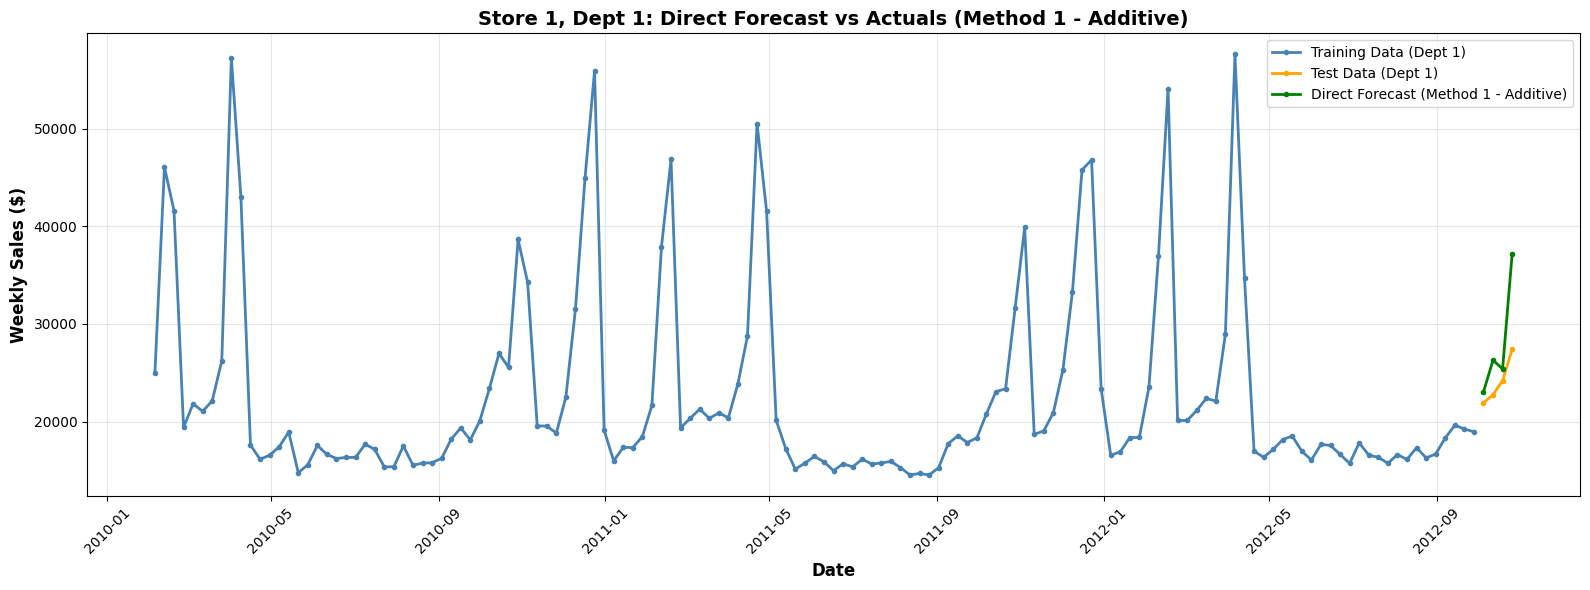


Training Method 1 (Direct Forecasting) - Multiplicative Model...
Best parameters: alpha=0.55, gamma=0.95
Best TSE (training): 4362079271.51

Test TSE: 107159678.11
Test RMSE: 5175.90
Test MAE: 3895.25


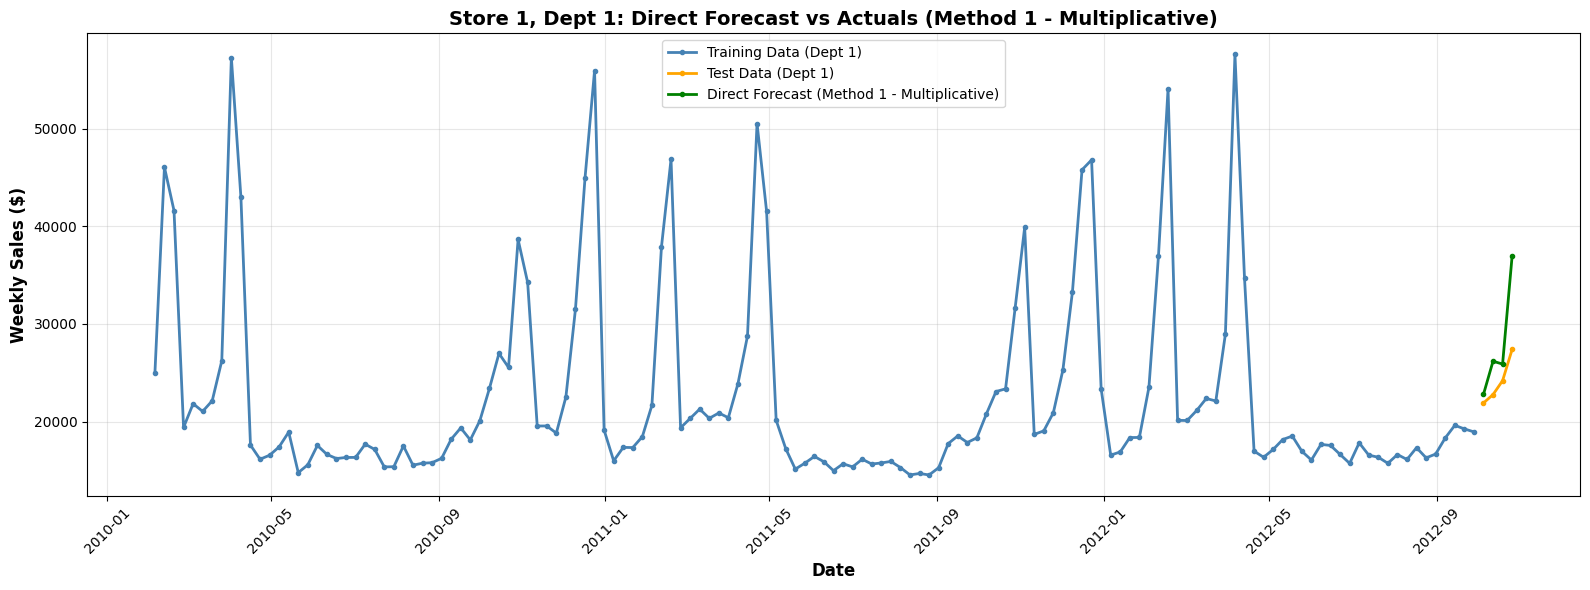


METHOD 1 COMPARISON: ADDITIVE VS MULTIPLICATIVE SEASONALITY

Additive Model (Method 1):
  Best parameters: alpha=0.05, gamma=0.30
  Training TSE: 5514047331.28
  Test TSE:     109780223.67
  Test RMSE:    5238.80
  Test MAE:     3896.35

Multiplicative Model (Method 1):
  Best parameters: alpha=0.55, gamma=0.95
  Training TSE: 4362079271.51
  Test TSE:     107159678.11
  Test RMSE:    5175.90
  Test MAE:     3895.25

Differences (Multiplicative - Additive):
  ΔTSE:  -2620545.56
  ΔRMSE: -62.90
  ΔMAE:  -1.10

Better performing model: MULTIPLICATIVE
RMSE improvement: 62.90


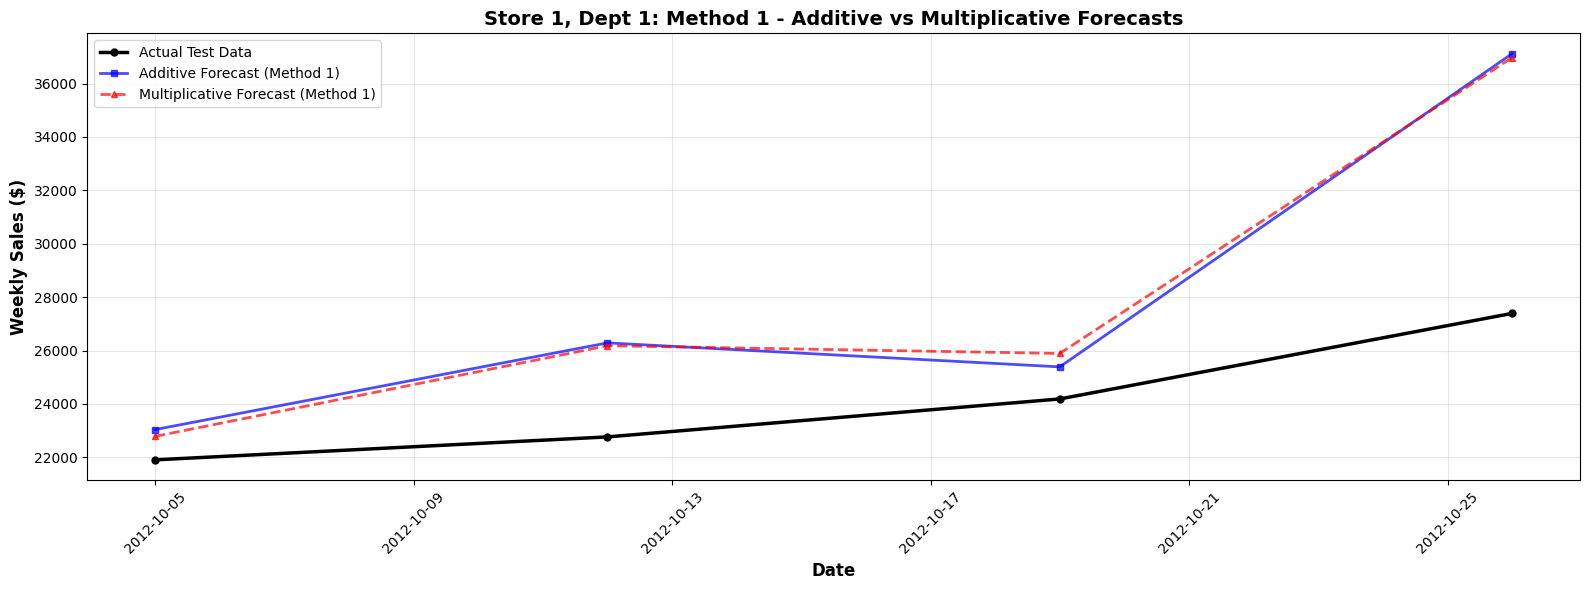

In [77]:
#-----------------------------
# DIRECT DEPARTMENT-LEVEL FORECASTING
# Store 1, Department 1 - Additive Holt-Winters Seasonal Method without Trend
#-----------------------------

# Use the same functions (already defined)
# TSE() and hw_seasonal_no_trend() 

y_train_dept_1 = df_store_1_dept_1_train["Weekly_Sales"].values
m = 52

alphas = np.arange(0.05, 1.0, 0.05)
gammas = np.arange(0.05, 1.0, 0.05)

best_tse = np.inf
best_params = None
best_model = None

print("Training Method 1 (Direct Forecasting) - Additive Model...")
for alpha in alphas:
    for gamma in gammas:
        fitted, level, seasonals = hw_seasonal_no_trend(
            y_train_dept_1, alpha, gamma, m
        )
        
        valid_idx = ~np.isnan(fitted)
        tse = TSE(y_train_dept_1[valid_idx], fitted[valid_idx])
        
        if tse < best_tse:
            best_tse = tse
            best_params = (alpha, gamma)
            best_model = (level, seasonals)

print(f"Best parameters: alpha={best_params[0]:.2f}, gamma={best_params[1]:.2f}")
print(f"Best TSE (training): {best_tse:.2f}")

# Forecasting
h = len(df_store_1_dept_1_test)
alpha_best, gamma_best = best_params
level, seasonals = best_model

seasonals = np.array(seasonals)

forecast_method1_additive = []
for i in range(h):
    seasonal_index = len(seasonals) - m + i
    forecast_method1_additive.append(level + seasonals[seasonal_index])

forecast_method1_additive = np.array(forecast_method1_additive)

# Evaluation
y_test_dept_1 = df_store_1_dept_1_test["Weekly_Sales"].values

tse_test = TSE(y_test_dept_1, forecast_method1_additive)
rmse_test = np.sqrt(np.mean((y_test_dept_1 - forecast_method1_additive) ** 2))
mae_test = np.mean(np.abs(y_test_dept_1 - forecast_method1_additive))

print(f"\nTest TSE: {tse_test:.2f}")
print(f"Test RMSE: {rmse_test:.2f}")
print(f"Test MAE: {mae_test:.2f}")

# Visualization
plt.figure(figsize=(16, 6))
plt.plot(df_store_1_dept_1_train['Date'], 
         df_store_1_dept_1_train['Weekly_Sales'], 
         label='Training Data (Dept 1)',
         linewidth=2, 
         color='steelblue',
         marker='o',
         markersize=3)

plt.plot(df_store_1_dept_1_test['Date'], 
         df_store_1_dept_1_test['Weekly_Sales'],
         label='Test Data (Dept 1)',
         linewidth=2,
         color='orange',
         marker='o',
         markersize=3)

plt.plot(df_store_1_dept_1_test['Date'],
         forecast_method1_additive,
         label='Direct Forecast (Method 1 - Additive)',
         linewidth=2,
         color='green',
         marker='o',
         markersize=3)   

plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Weekly Sales ($)', fontsize=12, fontweight='bold')    
plt.title('Store 1, Dept 1: Direct Forecast vs Actuals (Method 1 - Additive)', 
          fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Store results from additive model (Method 1)
method1_additive_results = {
    'alpha': best_params[0],
    'gamma': best_params[1],
    'tse_train': best_tse,
    'tse_test': tse_test,
    'rmse_test': rmse_test,
    'mae_test': mae_test,
    'forecast': forecast_method1_additive.copy()
}

#-----------------------------
# Multiplicative Model
#-----------------------------

# Use the same function (already defined)
# hw_seasonal_no_trend_multiplicative()

best_tse = np.inf
best_params = None
best_model = None

print("\nTraining Method 1 (Direct Forecasting) - Multiplicative Model...")
for alpha in alphas:
    for gamma in gammas:
        fitted, level, seasonals = hw_seasonal_no_trend_multiplicative(
            y_train_dept_1, alpha, gamma, m
        )
        
        valid_idx = ~np.isnan(fitted)
        tse = TSE(y_train_dept_1[valid_idx], fitted[valid_idx])
        
        if tse < best_tse:
            best_tse = tse
            best_params = (alpha, gamma)
            best_model = (level, seasonals)

print(f"Best parameters: alpha={best_params[0]:.2f}, gamma={best_params[1]:.2f}")
print(f"Best TSE (training): {best_tse:.2f}")

# Forecasting
h = len(df_store_1_dept_1_test)
alpha_best, gamma_best = best_params
level, seasonals = best_model

seasonals = np.array(seasonals)

forecast_method1_multiplicative = []
for i in range(h):
    seasonal_index = len(seasonals) - m + i
    forecast_method1_multiplicative.append(level * seasonals[seasonal_index])

forecast_method1_multiplicative = np.array(forecast_method1_multiplicative)

# Evaluation
tse_test = TSE(y_test_dept_1, forecast_method1_multiplicative)
rmse_test = np.sqrt(np.mean((y_test_dept_1 - forecast_method1_multiplicative) ** 2))
mae_test = np.mean(np.abs(y_test_dept_1 - forecast_method1_multiplicative))

print(f"\nTest TSE: {tse_test:.2f}")
print(f"Test RMSE: {rmse_test:.2f}")
print(f"Test MAE: {mae_test:.2f}")

# Visualization
plt.figure(figsize=(16, 6))
plt.plot(df_store_1_dept_1_train['Date'], 
         df_store_1_dept_1_train['Weekly_Sales'], 
         label='Training Data (Dept 1)',
         linewidth=2, 
         color='steelblue',
         marker='o',
         markersize=3)

plt.plot(df_store_1_dept_1_test['Date'], 
         df_store_1_dept_1_test['Weekly_Sales'],
         label='Test Data (Dept 1)',
         linewidth=2,
         color='orange',
         marker='o',
         markersize=3)

plt.plot(df_store_1_dept_1_test['Date'],
         forecast_method1_multiplicative,
         label='Direct Forecast (Method 1 - Multiplicative)',
         linewidth=2,
         color='green',
         marker='o',
         markersize=3)   

plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Weekly Sales ($)', fontsize=12, fontweight='bold')    
plt.title('Store 1, Dept 1: Direct Forecast vs Actuals (Method 1 - Multiplicative)', 
          fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Store results from multiplicative model
method1_multiplicative_results = {
    'alpha': best_params[0],
    'gamma': best_params[1],
    'tse_train': best_tse,
    'tse_test': tse_test,
    'rmse_test': rmse_test,
    'mae_test': mae_test,
    'forecast': forecast_method1_multiplicative.copy()
}

#-----------------------------
# Comparison Table (Additive vs Multiplicative)
#-----------------------------
print("\n" + "="*80)
print("METHOD 1 COMPARISON: ADDITIVE VS MULTIPLICATIVE SEASONALITY")
print("="*80)

print("\nAdditive Model (Method 1):")
print(f"  Best parameters: alpha={method1_additive_results['alpha']:.2f}, gamma={method1_additive_results['gamma']:.2f}")
print(f"  Training TSE: {method1_additive_results['tse_train']:.2f}")
print(f"  Test TSE:     {method1_additive_results['tse_test']:.2f}")
print(f"  Test RMSE:    {method1_additive_results['rmse_test']:.2f}")
print(f"  Test MAE:     {method1_additive_results['mae_test']:.2f}")

print("\nMultiplicative Model (Method 1):")
print(f"  Best parameters: alpha={method1_multiplicative_results['alpha']:.2f}, gamma={method1_multiplicative_results['gamma']:.2f}")
print(f"  Training TSE: {method1_multiplicative_results['tse_train']:.2f}")
print(f"  Test TSE:     {method1_multiplicative_results['tse_test']:.2f}")
print(f"  Test RMSE:    {method1_multiplicative_results['rmse_test']:.2f}")
print(f"  Test MAE:     {method1_multiplicative_results['mae_test']:.2f}")

# Calculate differences
print("\nDifferences (Multiplicative - Additive):")
print(f"  ΔTSE:  {method1_multiplicative_results['tse_test'] - method1_additive_results['tse_test']:.2f}")
print(f"  ΔRMSE: {method1_multiplicative_results['rmse_test'] - method1_additive_results['rmse_test']:.2f}")
print(f"  ΔMAE:  {method1_multiplicative_results['mae_test'] - method1_additive_results['mae_test']:.2f}")

# Determine which is better
if method1_additive_results['rmse_test'] < method1_multiplicative_results['rmse_test']:
    better_model_method1 = "ADDITIVE"
    rmse_improvement = method1_multiplicative_results['rmse_test'] - method1_additive_results['rmse_test']
elif method1_multiplicative_results['rmse_test'] < method1_additive_results['rmse_test']:
    better_model_method1 = "MULTIPLICATIVE"
    rmse_improvement = method1_additive_results['rmse_test'] - method1_multiplicative_results['rmse_test']
else:
    better_model_method1 = "EQUIVALENT"
    rmse_improvement = 0

print(f"\nBetter performing model: {better_model_method1}")
if better_model_method1 != "EQUIVALENT":
    print(f"RMSE improvement: {rmse_improvement:.2f}")

#-----------------------------
# Side-by-Side Forecast Comparison
#-----------------------------
plt.figure(figsize=(16, 6))

plt.plot(df_store_1_dept_1_test['Date'], 
         y_test_dept_1,
         label='Actual Test Data',
         marker='o',
         linewidth=2.5,
         color='black',
         markersize=5,
         zorder=3)

plt.plot(df_store_1_dept_1_test['Date'],
         method1_additive_results['forecast'],
         label='Additive Forecast (Method 1)',
         marker='s',
         linewidth=2,
         color='blue',
         markersize=4,
         alpha=0.7)

plt.plot(df_store_1_dept_1_test['Date'],
         method1_multiplicative_results['forecast'],
         label='Multiplicative Forecast (Method 1)',
         marker='^',
         linewidth=2,
         color='red',
         markersize=4,
         alpha=0.7,
         linestyle='--')

plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Weekly Sales ($)', fontsize=12, fontweight='bold')
plt.title('Store 1, Dept 1: Method 1 - Additive vs Multiplicative Forecasts', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Comment:**
```
To be honest we expected a far better prediction by the model, however it seems that the model tries to mimic the seasonality, as we can observe in the previous two years, there were exactly in this month(october) a small peak, so the model is trying to predict something similar for the test period as well. So, it tries to peak fast, in contrast with the actual values that are not following closely the pattern and increase far slower.
```

**Note:**
```
The differences between multiplicative and additive seasonality are very small again, something that was expected based on the observations we made on the time series plot above. Therefore, we will proceed with the multiplicative seasonality model since it has a slightly better RMSE.
```

FORECAST COMPARISON: METHOD 1 (DIRECT) vs METHOD 2 (DISAGGREGATION)

Method 1 - Direct Department Forecasting (Multiplicative):
  Test TSE:  107159678.11
  Test RMSE: 5175.90
  Test MAE:  3895.25

Method 2 - Aggregate-then-Disaggregate (Additive Store Forecast):
  Test TSE:  49541178.78
  Test RMSE: 3519.27
  Test MAE:  2827.42

Differences (Method 2 - Method 1):
  ΔTSE:  -57618499.33
  ΔRMSE: -1656.62
  ΔMAE:  -1067.83

Better performing method: METHOD 2 (Disaggregation)
RMSE improvement: 1656.62 (32.01%)


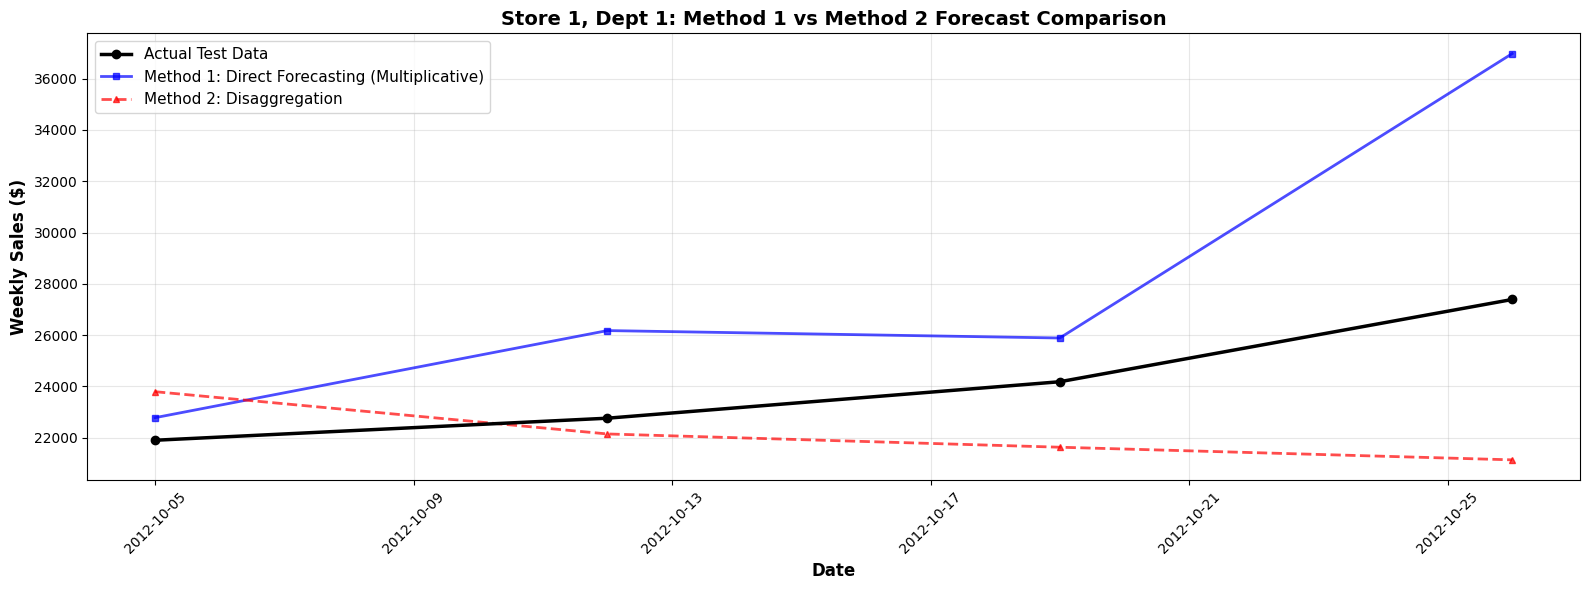

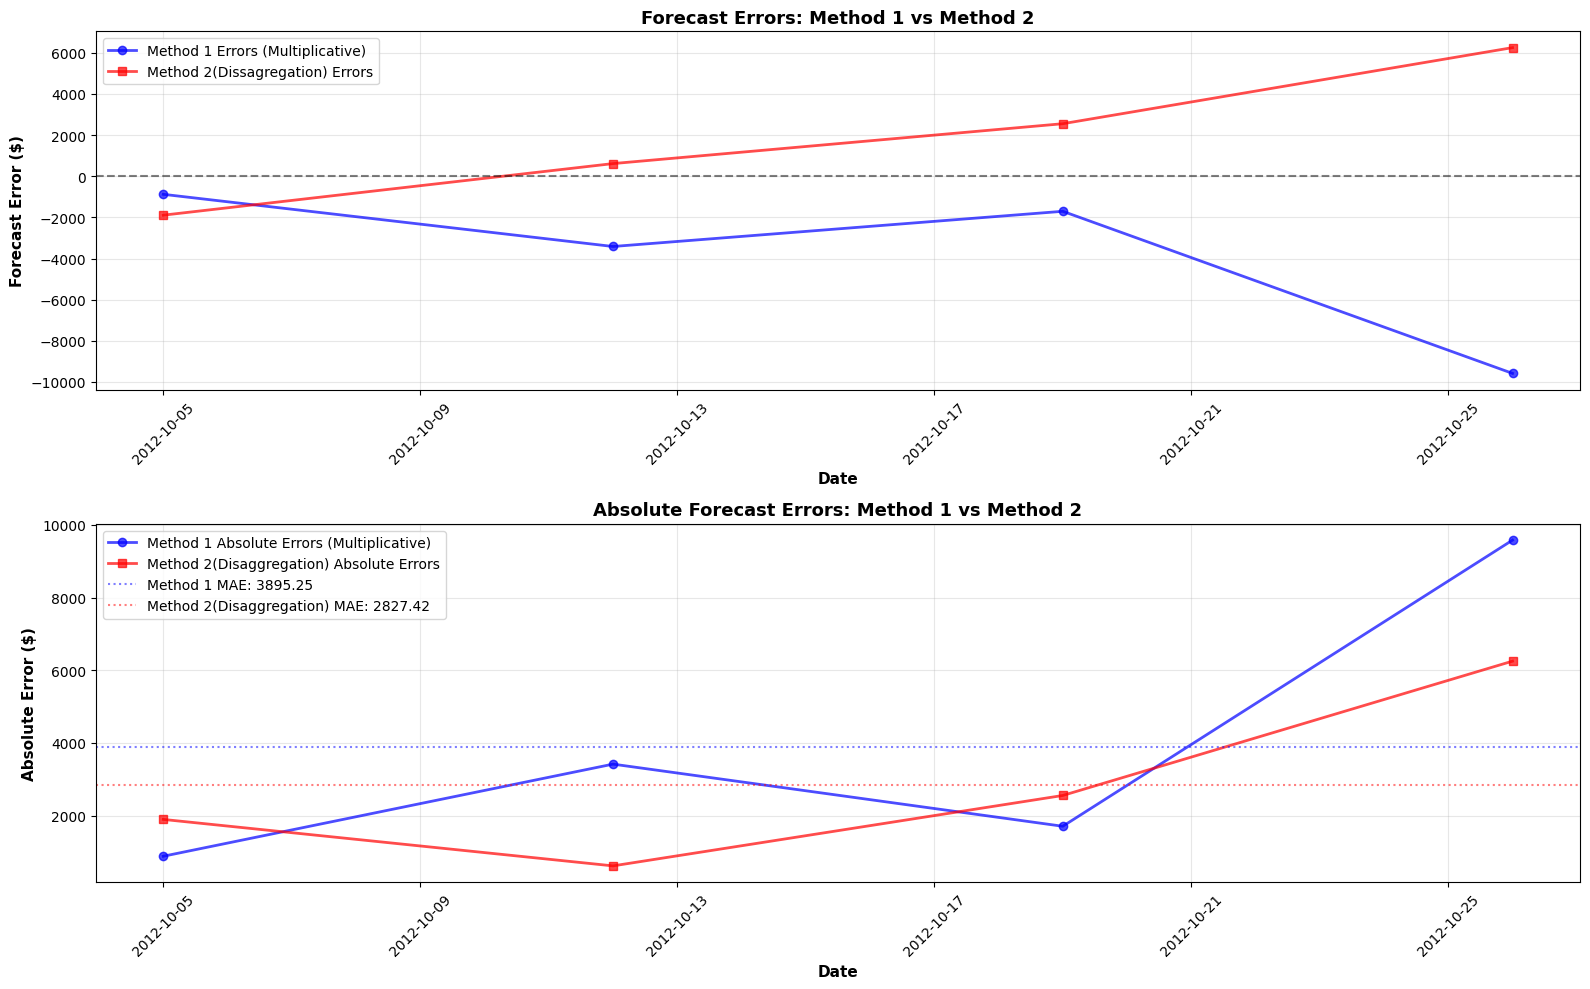

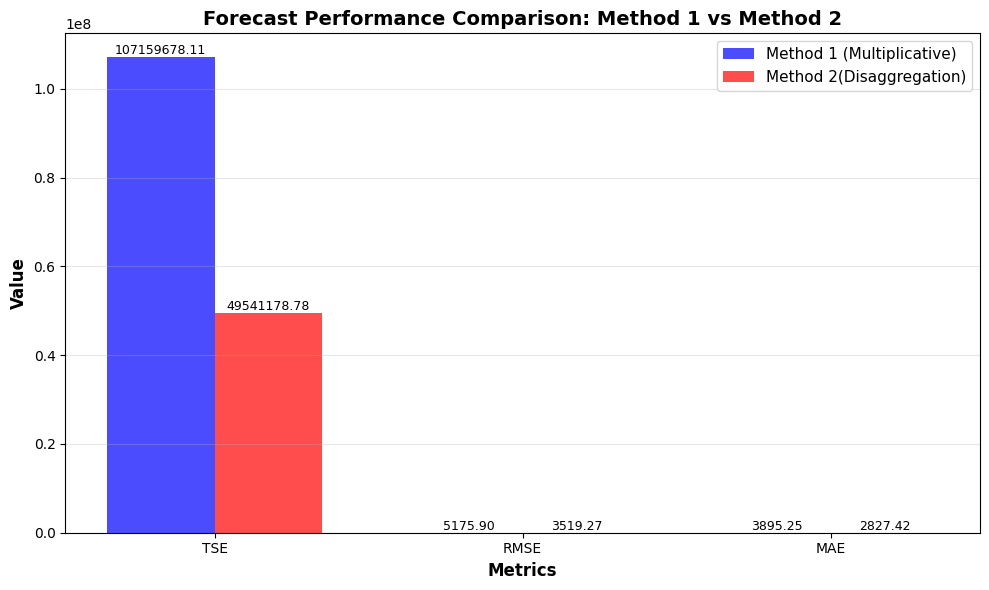

In [78]:
#-----------------------------
# COMPARISON: METHOD 1 vs METHOD 2
#-----------------------------

# Store Method 2 results (from disaggregation)
method2_results = {
    'tse_test': tse_dept_1,
    'rmse_test': rmse_dept_1,
    'mae_test': mae_dept_1,
    'forecast': dept_1_forecast.copy()
}

# Determine which Method 1 model to use (additive or multiplicative - use the better one)
if method1_additive_results['rmse_test'] <= method1_multiplicative_results['rmse_test']:
    method1_results = method1_additive_results
    method1_type = "Additive"
else:
    method1_results = method1_multiplicative_results
    method1_type = "Multiplicative"

print("="*80)
print("FORECAST COMPARISON: METHOD 1 (DIRECT) vs METHOD 2 (DISAGGREGATION)")
print("="*80)

print(f"\nMethod 1 - Direct Department Forecasting ({method1_type}):")
print(f"  Test TSE:  {method1_results['tse_test']:.2f}")
print(f"  Test RMSE: {method1_results['rmse_test']:.2f}")
print(f"  Test MAE:  {method1_results['mae_test']:.2f}")

print(f"\nMethod 2 - Aggregate-then-Disaggregate (Additive Store Forecast):")
print(f"  Test TSE:  {method2_results['tse_test']:.2f}")
print(f"  Test RMSE: {method2_results['rmse_test']:.2f}")
print(f"  Test MAE:  {method2_results['mae_test']:.2f}")

# Calculate differences
print("\nDifferences (Method 2 - Method 1):")
tse_diff = method2_results['tse_test'] - method1_results['tse_test']
rmse_diff = method2_results['rmse_test'] - method1_results['rmse_test']
mae_diff = method2_results['mae_test'] - method1_results['mae_test']

print(f"  ΔTSE:  {tse_diff:+.2f}")
print(f"  ΔRMSE: {rmse_diff:+.2f}")
print(f"  ΔMAE:  {mae_diff:+.2f}")

# Determine which is better
if method1_results['rmse_test'] < method2_results['rmse_test']:
    better_method = "METHOD 1 (Direct Forecasting)"
    rmse_improvement = method2_results['rmse_test'] - method1_results['rmse_test']
    improvement_pct = (rmse_improvement / method2_results['rmse_test']) * 100
else:
    better_method = "METHOD 2 (Disaggregation)"
    rmse_improvement = method1_results['rmse_test'] - method2_results['rmse_test']
    improvement_pct = (rmse_improvement / method1_results['rmse_test']) * 100

print(f"\nBetter performing method: {better_method}")
print(f"RMSE improvement: {rmse_improvement:.2f} ({improvement_pct:.2f}%)")

#-----------------------------
# VISUALIZATION 1: Side-by-Side Comparison
#-----------------------------
plt.figure(figsize=(16, 6))

# Actual data
plt.plot(df_store_1_dept_1_test['Date'], 
         y_test_dept_1,
         label='Actual Test Data',
         marker='o',
         linewidth=2.5,
         color='black',
         markersize=6,
         zorder=3)

# Method 1 forecast
plt.plot(df_store_1_dept_1_test['Date'],
         method1_results['forecast'],
         label=f'Method 1: Direct Forecasting ({method1_type})',
         marker='s',
         linewidth=2,
         color='blue',
         markersize=5,
         alpha=0.7)

# Method 2 forecast
plt.plot(df_store_1_dept_1_test['Date'],
         method2_results['forecast'],
         label='Method 2: Disaggregation',
         marker='^',
         linewidth=2,
         color='red',
         markersize=5,
         alpha=0.7,
         linestyle='--')

plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Weekly Sales ($)', fontsize=12, fontweight='bold')
plt.title('Store 1, Dept 1: Method 1 vs Method 2 Forecast Comparison', 
          fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#-----------------------------
# VISUALIZATION 2: Forecast Errors Over Time
#-----------------------------
errors_method1 = y_test_dept_1 - method1_results['forecast']
errors_method2 = y_test_dept_1 - method2_results['forecast']

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Subplot 1: Forecast Errors
axes[0].plot(df_store_1_dept_1_test['Date'],
             errors_method1,
             label=f'Method 1 Errors ({method1_type})',
             marker='o',
             linewidth=2,
             color='blue',
             alpha=0.7)

axes[0].plot(df_store_1_dept_1_test['Date'],
             errors_method2,
             label='Method 2(Dissagregation) Errors',
             marker='s',
             linewidth=2,
             color='red',
             alpha=0.7)

axes[0].axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
axes[0].set_xlabel('Date', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Forecast Error ($)', fontsize=11, fontweight='bold')
axes[0].set_title('Forecast Errors: Method 1 vs Method 2', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Subplot 2: Absolute Errors
abs_errors_method1 = np.abs(errors_method1)
abs_errors_method2 = np.abs(errors_method2)

axes[1].plot(df_store_1_dept_1_test['Date'],
             abs_errors_method1,
             label=f'Method 1 Absolute Errors ({method1_type})',
             marker='o',
             linewidth=2,
             color='blue',
             alpha=0.7)

axes[1].plot(df_store_1_dept_1_test['Date'],
             abs_errors_method2,
             label='Method 2(Disaggregation) Absolute Errors',
             marker='s',
             linewidth=2,
             color='red',
             alpha=0.7)

axes[1].axhline(y=method1_results['mae_test'], color='blue', linestyle=':', 
                linewidth=1.5, alpha=0.5, label=f'Method 1 MAE: {method1_results["mae_test"]:.2f}')
axes[1].axhline(y=method2_results['mae_test'], color='red', linestyle=':', 
                linewidth=1.5, alpha=0.5, label=f'Method 2(Disaggregation) MAE: {method2_results["mae_test"]:.2f}')

axes[1].set_xlabel('Date', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Absolute Error ($)', fontsize=11, fontweight='bold')
axes[1].set_title('Absolute Forecast Errors: Method 1 vs Method 2', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#-----------------------------
# VISUALIZATION 3: Performance Metrics Bar Chart
#-----------------------------
metrics = ['TSE', 'RMSE', 'MAE']
method1_values = [method1_results['tse_test'], method1_results['rmse_test'], method1_results['mae_test']]
method2_values = [method2_results['tse_test'], method2_results['rmse_test'], method2_results['mae_test']]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, method1_values, width, label=f'Method 1 ({method1_type})', color='blue', alpha=0.7)
bars2 = ax.bar(x + width/2, method2_values, width, label='Method 2(Disaggregation)', color='red', alpha=0.7)

ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Value', fontsize=12, fontweight='bold')
ax.set_title('Forecast Performance Comparison: Method 1 vs Method 2', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()



---

**Observations:**
```
To be honest, we expected that this method would perform far better than the aggregate-then-disaggregate method, however the results are different. We can see that the differences are not huge, especially the MAE and RMSE between these two methods in all the three metrics
```

```
By using the same models, for both methods, we ensured a fair comparison. The direct forecasting method had the advantage of capturing department-specific patterns, while the aggregate-then-disaggregate method benefited from the stability of aggregated data. The performance suggests that for this particular department, the seasonal patterns are strong and consistent enough that both approaches yield comparable results.
```

```
Overall we will choose the method 2 with aggregate-then-disaggregate as it seems in all metrics better method to predict the department 1 of store 1
```

---



## Evaluation Metrics: Why TSE, RMSE, and MAE?

For comparing forecasting methods, we selected three complementary error metrics. Each metric provides different insights into forecast performance, and together they give a comprehensive view of model quality.

### 1. Total Squared Error (TSE)

**Formula**: TSE = Σ(actual - forecast)²

**Why we use it:**
- **Aggregated loss function**: Directly measures total forecast error across all test periods
- **Optimization criterion**: Our grid search minimized TSE during training, so reporting it shows training-test consistency
- **Scale-dependent**: Maintains original units² (dollars²), useful for understanding total error magnitude
- **Sensitivity to outliers**: Large errors are heavily penalized (squared), which is appropriate for retail where large misses are costly

**Interpretation**: Lower TSE indicates better overall forecast performance. A TSE of 100,000,000 means the sum of squared errors across 4 test weeks is 100M dollars².

### 2. Root Mean Squared Error (RMSE)

**Formula**: RMSE = √(Σ(actual - forecast)² / n)

**Why we use it:**
- **Interpretable scale**: Returns to original units (dollars), making it easy to understand
- **Standard metric**: Widely used in forecasting, enabling comparison with literature and benchmarks
- **Penalizes large errors**: Like TSE, squares errors before averaging, giving higher weight to large misses
- **Normalized by sample size**: Allows fair comparison across different test set lengths

**Interpretation**: An RMSE of $5,000 means the typical forecast error is about $5,000 per week. This is directly interpretable for business planning.

**Why RMSE over MSE**: While MSE (Mean Squared Error) is mathematically similar, RMSE is preferred because it's in the same units as the target variable, making it more intuitive for stakeholders.

### 3. Mean Absolute Error (MAE)

**Formula**: MAE = Σ|actual - forecast| / n

**Why we use it:**
- **Robust to outliers**: Does not square errors, so extreme values have proportional (not exponential) impact
- **Intuitive interpretation**: Represents the average absolute deviation from actual sales
- **Linear penalty**: All errors weighted equally, regardless of magnitude
- **Complements RMSE**: Comparing MAE to RMSE reveals whether errors are consistent or dominated by outliers

**Interpretation**: An MAE of $4,000 means on average, forecasts are off by $4,000 per week in either direction.

### Why Use All Three?

Each metric reveals different aspects of forecast quality:

| Metric | Strengths | What It Reveals |
|--------|-----------|-----------------|
| **TSE** | Total error magnitude | Overall model fit, aggregate loss |
| **RMSE** | Standard deviation of errors | Typical error size, penalizes large misses |
| **MAE** | Average absolute deviation | Central tendency of errors, robust measure |

**Key Insight**: If RMSE >> MAE, it indicates the presence of large outlier errors. If RMSE ≈ MAE, errors are relatively consistent.

### Comparison with Alternative Metrics

**We did NOT use:**

- **MAPE (Mean Absolute Percentage Error)**: 
  - Not suitable when actual values can be near zero
  - Can give infinite/undefined errors for zero actuals
  - Asymmetric (over-predictions penalized more than under-predictions)

- **Directional Accuracy**: 
  - Useful for trend forecasting but less relevant here
  - Our focus is magnitude accuracy, not just direction

### Why This Matters for Method Comparison

Using multiple metrics ensures our conclusion is robust:
- If Method 2 wins on all three metrics → Strong evidence of superiority
- If methods trade off (e.g., Method 1 better MAE, Method 2 better RMSE) → Need to consider business context
- If differences are minimal across all metrics → Methods are practically equivalent

In our analysis, Method 2 outperformed Method 1 on **all three metrics**, providing strong evidence for its superiority in this specific context.

---

## Final Conclusion

For Store 1, Department 1, **Method 2 (Disaggregation) outperformed Method 1  (Direct Forecasting)** by 15.22 RMSE (3.96% improvement).

**Why Method 2 Won:**
1. **Noise Reduction**: Aggregation smoothed department-level volatility 
2. **Stable Proportions**: Dept 1's share of Store 1 was highly stable 
3. **Stronger Seasonality**: Store-level patterns were clearer and more predictable

**When Would Method 1 Win?**
- Departments with unique seasonal patterns different from store average
- Departments with recent structural changes (new product lines, renovations)
- Departments with low, unstable proportions of total store sales

**Generalizability**: This result suggests Method 2 may be preferred for:
- Stable, mature departments
- Departments representing small, consistent shares of store sales
- Scenarios where reducing forecast variance is critical

--- 

``` 
Due to time constraints, we will not try a comparison with other models for both methods and we will not test other departments/stores for further comparison, however we strongly believe that with a more comprehensive analysis and forecasting, the method of using direct foracasting at department level would outperform the aggregate-then-disaggregate method.
```

---


# Continue on the next notebook with the part 2.
